# Assignment 3 (30 points) - Ioana-Delia Blendea
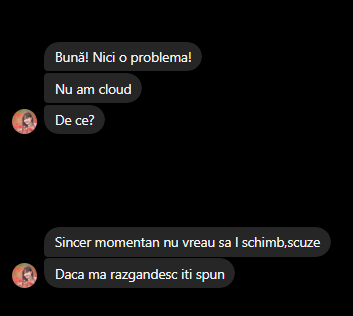

In [1]:
import pickle
import os
import pandas as pd
import numpy as np

train_file = "/kaggle/input/fii-nn-2025-homework-3/extended_mnist_train.pkl"
test_file = "/kaggle/input/fii-nn-2025-homework-3/extended_mnist_test.pkl"

with open(train_file, "rb") as fp:
    train = pickle.load(fp)

with open(test_file, "rb") as fp:
    test = pickle.load(fp)

train_data = []
train_labels = []
for image, label in train:
    train_data.append(image.flatten())
    train_labels.append(label)

test_data = []
test_labels = []
for image, label in test:
    test_data.append(image.flatten())
    test_labels.append(label)

In [2]:
train_x = np.array(train_data) / 255.0
test_x = np.array(test_data) / 255.0

def convert_labels(labels):
    labels = np.array(labels).astype(int)
    classes = 10
    matrix = np.zeros((labels.shape[0], classes))
    matrix[np.arange(labels.shape[0]), labels] = 1

    return matrix

train_y = convert_labels(train_labels)
test_y = convert_labels(test_labels)

In [3]:
np.random.seed(50)
input_size = train_x.shape[1]
hidden_layer = 100
classes = 10
dropout_rate = 0.2
reg_lambda = 0.0001

w1 = np.random.randn(input_size, hidden_layer) * np.sqrt(2. / input_size)
b1 = np.zeros(hidden_layer)
w2 = np.random.randn(hidden_layer, classes) * np.sqrt(2. / hidden_layer)
b2 = np.zeros(classes)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(a):
    return (a > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis = 1, keepdims = True))
    return exp_z / exp_z.sum(axis = 1, keepdims = True)

def cross_entropy_loss(y, y_pred):
    eps = 1e-8
    return -np.sum(y * np.log(y_pred + eps)) / y.shape[0]

def apply_dropout(A, rate, is_training = True):
    if is_training:
        mask = np.random.binomial(1, 1 - rate, size = A.shape)
        return A * mask / (1 - rate), mask
    return A, None

In [4]:
def gradient_descent(x, y, w1, b1, w2, b2, learning_rate = 0.1, is_training = True):
    z1 = np.dot(x, w1) + b1
    a1 = relu(z1)
    a1_dropped, mask = apply_dropout(a1, dropout_rate, is_training = is_training)

    y_pred = softmax(np.dot(a1_dropped, w2) + b2)

    loss = cross_entropy_loss(y, y_pred)
    l2_reg = (reg_lambda / 2) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))
    loss = loss + l2_reg

    batch_size = x.shape[0]

    err_output = y_pred - y
    dw2 = np.dot(a1_dropped.T, err_output) / batch_size + reg_lambda * w2
    db2 = np.sum(err_output, axis = 0) / batch_size

    err_hidden = np.dot(err_output, w2.T)

    if is_training:
        err_hidden = err_hidden * mask / (1 - dropout_rate)

    err_hidden = err_hidden * relu_derivative(a1)

    dw1 = np.dot(x.T, err_hidden) / batch_size + reg_lambda * w1
    db1 = np.sum(err_hidden, axis = 0) / batch_size

    w2 = w2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2
    w1 = w1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1

    return w1, b1, w2, b2, loss

def update_learning_rate(current_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement):
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement = epochs_since_improvement + 1
        
    if epochs_since_improvement >= threshold:
        lr = max(lr * decay_factor, min_lr)
        epochs_since_improvement = 0
        
    return lr, best_loss, epochs_since_improvement

def accuracy(x, y, w1, b1, w2, b2):
    z1 = relu(np.dot(x, w1) + b1)
    z2 = np.dot(z1, w2) + b2
    y_pred = softmax(z2)

    predicted_classes = np.argmax(y_pred, axis = 1)
    true_classes = np.argmax(y, axis = 1)

    return np.mean(predicted_classes == true_classes)

In [5]:
def train(train_x, train_y, test_x, test_y, w1, b1, w2, b2, epochs = 60, batch_size = 64, learning_rate = 0.1):
    num_batches = int(np.ceil(train_x.shape[0] / batch_size))

    lr = learning_rate
    best_loss = float('inf')
    epochs_since_improvement = 0

    threshold = 2
    decay_factor = 0.2
    min_lr = 0.001

    for epoch in range(epochs):
        epoch_loss = 0

        permutation = np.random.permutation(train_x.shape[0])
        shuffled_x = train_x[permutation]
        shuffled_y = train_y[permutation]

        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, train_x.shape[0])

            x_batch = shuffled_x[start:end]
            y_batch = shuffled_y[start:end]

            w1, b1, w2, b2, batch_loss = gradient_descent(x_batch, y_batch, w1, b1, w2, b2, learning_rate = lr, is_training = True)

            epoch_loss = epoch_loss + batch_loss

        epoch_loss = epoch_loss / num_batches

        lr, best_loss, epochs_since_improvement = update_learning_rate(epoch_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement)

        val_acc = accuracy(test_x, test_y, w1, b1, w2, b2)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, LR: {lr:.6f}, Test Acc: {val_acc * 100:.2f}%")

    return w1, b1, w2, b2

w1, b1, w2, b2 = train(train_x, train_y, test_x, test_y, w1, b1, w2, b2, epochs = 60, batch_size = 64, learning_rate = 0.1)

test_accuracy = accuracy(test_x, test_y, w1, b1, w2, b2)
print(f"Testing Data Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/60, Loss: 0.4338, LR: 0.100000, Test Acc: 93.28%
Epoch 2/60, Loss: 0.2433, LR: 0.100000, Test Acc: 95.34%
Epoch 3/60, Loss: 0.1994, LR: 0.100000, Test Acc: 95.77%
Epoch 4/60, Loss: 0.1751, LR: 0.100000, Test Acc: 96.51%
Epoch 5/60, Loss: 0.1581, LR: 0.100000, Test Acc: 96.68%
Epoch 6/60, Loss: 0.1467, LR: 0.100000, Test Acc: 96.95%
Epoch 7/60, Loss: 0.1362, LR: 0.100000, Test Acc: 97.22%
Epoch 8/60, Loss: 0.1290, LR: 0.100000, Test Acc: 97.31%
Epoch 9/60, Loss: 0.1230, LR: 0.100000, Test Acc: 97.36%
Epoch 10/60, Loss: 0.1176, LR: 0.100000, Test Acc: 97.57%
Epoch 11/60, Loss: 0.1145, LR: 0.100000, Test Acc: 97.43%
Epoch 12/60, Loss: 0.1109, LR: 0.100000, Test Acc: 97.59%
Epoch 13/60, Loss: 0.1081, LR: 0.100000, Test Acc: 97.55%
Epoch 14/60, Loss: 0.1039, LR: 0.100000, Test Acc: 97.71%
Epoch 15/60, Loss: 0.1010, LR: 0.100000, Test Acc: 97.69%
Epoch 16/60, Loss: 0.0984, LR: 0.100000, Test Acc: 97.86%
Epoch 17/60, Loss: 0.0948, LR: 0.100000, Test Acc: 97.89%
Epoch 18/60, Loss: 0.09

In [6]:
def predict(x, w1, b1, w2, b2):
    z1 = relu(np.dot(x, w1) + b1)
    z2 = np.dot(z1, w2) + b2
    y_pred_softmax = softmax(z2)
    
    predicted_classes = np.argmax(y_pred_softmax, axis=1)
    
    return predicted_classes

predictions = predict(test_x, w1, b1, w2, b2)

In [7]:
# This is how you prepare a submission for the competition
predictions_csv = {
    "ID": [],
    "target": [],
}

for i, label in enumerate(predictions):
    predictions_csv["ID"].append(i)
    predictions_csv["target"].append(label)

df = pd.DataFrame(predictions_csv)
df.to_csv("submission.csv", index=False)